In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

%matplotlib inline


In [2]:
from gmm_lbd import Sanitize_records_for_gmm

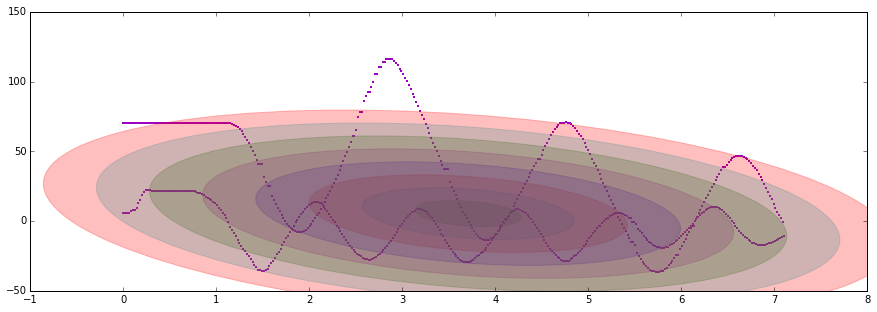

In [3]:
move_m1 = open('records/move_m1.record','r')
move_m2 = open('records/move_m2.record','r')

datas = Sanitize_records_for_gmm(1)

datas.add_move(move_m1)
datas.add_move(move_m2)

datas.plot_ellipses()

29 full


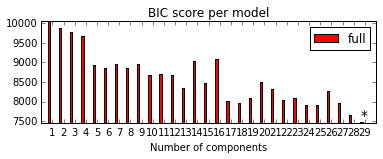

In [4]:
datas.plot_bics()
print datas.gmm.n_components,datas.gmm.covariance_type

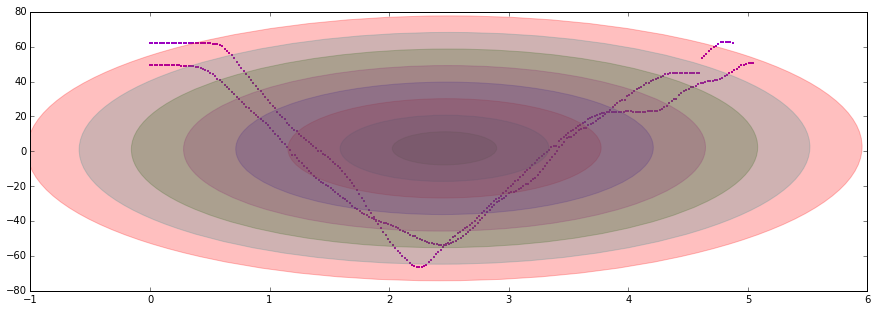

In [5]:
move_m1 = open('records/record_2_1.json','r')
move_m2 = open('records/record_2_2.json','r')

datas = Sanitize_records_for_gmm(1,n_components_range=range(1,20),cv_types=['spherical', 'tied', 'diag', 'full'])

datas.add_move(move_m1)
datas.add_move(move_m2)

#datas.plot_gmm()
datas.plot_ellipses()

## 1 motor multiple demo of sinus

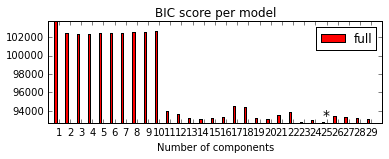

In [6]:
# number of demos
ndemo = 30

# number of periods
nperiod = np.pi

# motor specific
pmin = -60
pmax = 60

# record parameter
framerate = 10
tmin = 0
tmax = 20

# noise parameter
noise_amplitude =  0.2*(pmax-pmin) #30
noise_phase = np.pi/5#1.3
noise_time = 0.7#0.5


datas = Sanitize_records_for_gmm()


def _rand():
    return 2*(np.random.random(1)-1)

t=np.linspace(tmin,tmax,(tmax-tmin)*framerate)
y = ((pmax-pmin)/2)*np.sin(t*2*np.pi*nperiod/tmax) + (pmax+pmin)/2
datas.add_record(t,y)
mot_data = []
for i in xrange(ndemo):
    noisy_t =np.zeros(len(t))
    for n in range(len(t)):
        noisy_t[n] = t[n]+noise_time*np.random.random()
    y_noisy = (noise_amplitude*_rand())+ ((pmax-pmin)/2)*np.sin((noisy_t*2*np.pi*nperiod/tmax)+noise_phase*_rand()) + (pmax+pmin)/2
    mot_data.append(y_noisy)
    datas.add_record(noisy_t,y_noisy)


#for i in range(ndemo):
#    axes[i].plot(mot_data[i])

#datas.to_array()
datas.gen_gmm()
datas.plot_gmm()
datas.plot_bics()


#plot_mean_and_sdt(t,np.array(mot_data))


computed gmm 29
Selected gmm:  25 full


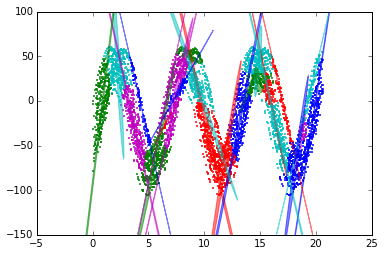

In [7]:
datas.plot_gmm()
print 'computed gmm',len(datas.bics)
print 'Selected gmm: ', datas.gmm.n_components,datas.gmm.covariance_type

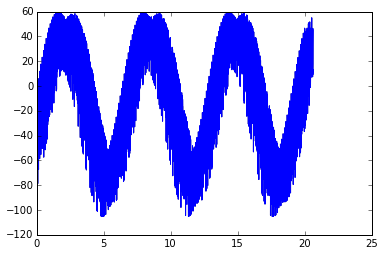

In [8]:
datas.plot(plot_type='mean')

NameError: name 'plot_mean_and_sdt' is not defined

In [33]:

#from sklearn.externals.six.moves import xrange

# Number of samples per component
n_samples = 70

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))

step = 4 * np.pi / n_samples

for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))



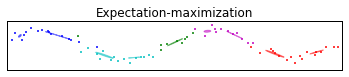

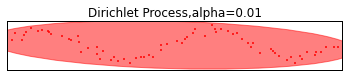

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars


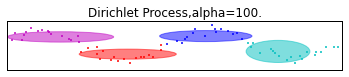

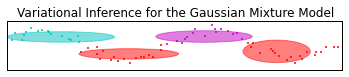

In [80]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])


for i, (clf, title) in enumerate([
        (mixture.GMM(n_components=10, covariance_type='full', n_iter=100),
         "Expectation-maximization"),
        (mixture.DPGMM(n_components=10, covariance_type='full', alpha=0.01,
                       n_iter=100),
         "Dirichlet Process,alpha=0.01"),
        (mixture.DPGMM(n_components=10, covariance_type='diag', alpha=100.,
                       n_iter=100),
         "Dirichlet Process,alpha=100."),
        (mixture.VBGMM(n_components=10, covariance_type='diag',n_iter=100),
         "Variational Inference for the Gaussian Mixture Model")]):
    
    clf.fit(X)
    splot = plt.subplot(4, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, 2*v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)


    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

([], <a list of 0 Text yticklabel objects>)

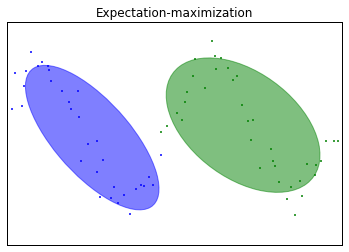

In [11]:
#from sklearn.externals.six.moves import xrange

# Number of samples per component
n_samples = 70

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))

step = 4 * np.pi / n_samples
t
for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))


color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

title = 'Expectation-maximization'
clf = mixture.VBGMM(n_components=4, covariance_type='full', n_iter=100)
clf.fit(X)
Y_ = clf.predict(X)
splot = plt.subplot(1,1,1)

for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        ## valeur propre, vecteur propre
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, 2*v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

plt.xlim(-6, 4 * np.pi - 6)
plt.ylim(-5, 5)
plt.title(title)
plt.xticks(())
plt.yticks(())
 



In [95]:
datas = Sanitize_records_for_gmm(0)